## Hide and Seek
#### Author: Andrei Gabriel Popescu, IA-B

In [332]:
from hide_and_seek.envs import HideAndSeekEnv, GameState, GameAction, Action, Reward
from hide_and_seek.envs import GridPosition, GridOrientation, GridRelativeOrientation
from random import choice
from time import sleep
import numpy as np
from gym import Env
import random
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Set env seed
HideAndSeekEnv.seed(42)

# Set random seed
random.seed(42)

# Set seaborn plotting type
sns.set(rc={'figure.figsize':(14, 10)})

### Create the game env 

In [333]:
env = HideAndSeekEnv(max_turns=20)
seeker_agent = DeterministicSeeker(env.w, env.h)
hider_agent = DummyHider()

In [334]:
class SimpleAgent:
    ag_ids = [1, 2]
    
    def __init__(self):
        self.total_reward = 0

    def get_action(self, state: GameState):
        return {ag_id: choice([e for e in Action]) for ag_id in SimpleAgent.ag_ids}

In [335]:
class DummyHider(SimpleAgent):
    pass

In [336]:
class DeterministicSeeker(SimpleAgent):
    
    def __init__(self, env_width, env_height):
        super(DeterministicSeeker, self).__init__()
        self._env_width = env_width
        self._env_height = env_height
        
        self._tactical_pos = GridPosition(self._env_width, self._env_height - 2)
        self._final_pos = GridPosition(self._env_width - 2, self._env_height - 4)
        
        self._tactical_pos_reached = False
        self._final_pos_reached = False
        
    def get_action(self, state: GameState):
        act1 = Action.NOP
        act2 = Action.NOP

        # get seeker positions
        seeker1_pos = state.seeker_positions[1]
        seeker2_pos = state.seeker_positions[2]
        
        if not self._tactical_pos_reached:
            # if seekers are not in the tactical position move them there
            
            if seeker1_pos != self._tactical_pos:
                # seeker 1 takes the north route
                if seeker1_pos.x == 1 and seeker1_pos.y != self._env_height:
                    # if seeker 1 is on the left shaft, move NORTH
                    act1 = Action.NORTH
                elif seeker1_pos.y == self._env_height and seeker1_pos.x != self._env_width:
                    # if seeker 1 is on the top shaft, EAST
                    act1 = Action.EAST
                elif seeker1_pos.x == self._env_width and seeker1_pos != self._tactical_pos:
                    # if seeker 1 is on the right shaft, SOUTH
                    act1 = Action.SOUTH
                    
            if seeker2_pos != self._tactical_pos:
                # seeker 2 takes the south route
                if seeker2_pos.x == 1 and seeker2_pos.y != 1:
                    # if seeker 2 is on the left shaft, move NORTH
                    act2 = Action.SOUTH
                elif seeker2_pos.y == 1 and seeker2_pos.x != self._env_width:
                    # if seeker 2 is on the bottom shaft, move EAST
                    act2 = Action.EAST
                elif seeker2_pos.x == self._env_width and seeker2_pos != self._tactical_pos:
                    # if seeker 2 is on the right shaft, move NORTH
                    act2 = Action.NORTH
                    
            if seeker1_pos == self._tactical_pos and seeker2_pos == self._tactical_pos:
                self._tactical_pos_reached = True
        
        else:
            if not self._final_pos_reached:
                # when seeker 1 and seeker 2 have reached the tactical position, move to the final one in tandem
                if seeker1_pos.y == self._tactical_pos.y and seeker1_pos.x != 3:
                    act1 = Action.WEST
                    act2 = Action.WEST
                elif seeker1_pos.x == 3 and seeker1_pos.y != self._final_pos.y:
                    act1 = Action.SOUTH
                    act2 = Action.SOUTH
                elif seeker1_pos.y == self._final_pos.y and seeker1_pos.x != self._final_pos.x:
                    act1 = Action.EAST
                    act2 = Action.EAST
                else:
                    self._final_pos_reached = True
            else:
                # if the agent made it thus far and the game has not ended, just make them move randomly
                return super(DeterministicSeeker, self).get_action(state)
                
        return {1: act1, 2: act2}

### Define the set of parameters

In [337]:
EPS = 0.1
STEPS = 5000
DEACY_EPS_DOWN = 0.1
DEACY_EPS_UP = 1.0
ALPHA = [0.1, 0.5]
GAMMA = [0.9, 0.99, 1.0]

### Off / On Policy Hider

In [338]:
def choose_action(Q: dict, state: GameState, eps: float = 0.0) -> dict:    
    if random.uniform(0, 1) < eps:
        return {ag_id: choice([e for e in Action]) for ag_id in SimpleAgent.ag_ids}
    else:
        if len(Q[state]) > 0:
            action = max(Q[state], key=Q[state].get)
            action = {1: action[0], 2: action[1]}
            return action
        else:
            return {ag_id: choice([e for e in Action]) for ag_id in SimpleAgent.ag_ids}

$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma \max_{a}Q[s_{t+1}, a] - Q[s_t, a])
$$

### Q-Learning: exponential decay

In [358]:
def OffPolicy( env: Env, 
               eps: float, 
               alpha: float,
               gamma: float,
               steps: int,
               expo_decay: bool = False,
               linear_decay: bool = False,
               decay_rate: float = 0.9,
               verbose: bool = False
             ):
    
    # Create two state-action helpers for both hiders
    Q = defaultdict(lambda: defaultdict(lambda: 0))    
    rewards = []
    
    linear_decay_eps = np.linspace(DEACY_EPS_UP, DEACY_EPS_DOWN, STEPS)

    
    for i in tqdm(range(steps), desc="Training"):
        state = env.reset()
        
        total_reward = 0    
        turn = 0
        
        for j in range(env.max_turns):
            turn += 1
            
            if linear_decay:
                eps = linear_decay_eps[i]
                actions = choose_action(Q=Q, state=state, eps=eps)
            elif expo_decay:
                eps = DEACY_EPS_DOWN + (eps - DEACY_EPS_DOWN) * np.exp(decay_rate * j) 
                actions = choose_action(Q=Q, state=state, eps=eps)
            else:
                actions = choose_action(Q=Q, state=state, eps=eps)
                
            hashable_structure = (actions[1], actions[2])
            
            seeker_actions = seeker_agent.get_action(state)
            hider_actions = actions
            
            game_action = GameAction(seeker_actions=seeker_actions, hider_actions=hider_actions)
            next_state, reward, done = env.step(action=game_action)
         
            total_reward += reward.total_hider_reward
            
            if done:
                break
                
            seeker_agent.total_reward += reward.total_seeker_reward
            hider_agent.total_reward += reward.total_hider_reward
            
            # Update the Q(state, action) with the new value for both hiders                           
            if len(Q[next_state]) > 0:
                Q[state][hashable_structure] = \
                    (1 - alpha) * Q[state][hashable_structure] \
                    + alpha * (reward.total_hider_reward + gamma * max(Q[next_state].values()))
            else:
                Q[state][hashable_structure] = \
                    (1 - alpha) * Q[state][hashable_structure] \
                    + alpha * (reward.total_hider_reward + gamma * 0)
            
            # Go to the new state
            state = next_state
            
            if verbose:
                print("## Turn: %i" % turn)
                print("\tSeeker actions: %s " % str(game_action.seeker_actions))
                print("\tSeeker reward: %6.2f" % seeker_agent.total_reward)
                print("\tHider actions: %s " % str(game_action.hider_actions))
                print("\tHider reward: %6.2f" % hider_agent.total_reward)
        
        rewards.append(total_reward)
    
    return rewards
       

### Test off policy learning

Training: 100%|█████████████████████████████████████████████████████████████████| 75000/75000 [05:07<00:00, 243.94it/s]


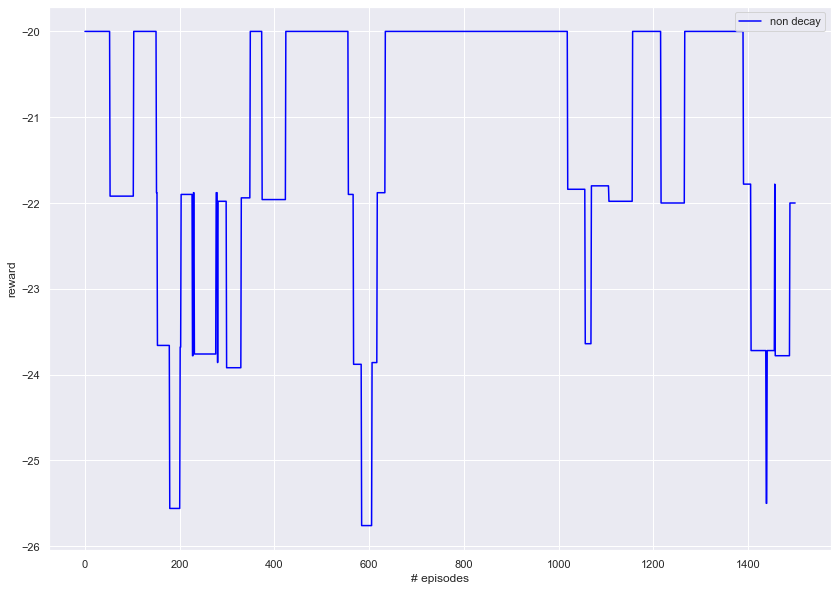

In [364]:
 rewards = OffPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      alpha=0.75,
                      gamma=0.95,
                      steps=75000,
                      verbose=False,
                    )
    
mean_rewards = [sum(rewards[i: i + 50]) / 50 for i in range(75000 // 50)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color='blue', label="non decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

### SARSA: On Policy

$$
  Q[s_t, a] = Q[s_t, a] + \alpha(R + \gamma Q[s_{t+1}, a'] - Q[s_t, a])
$$


In [346]:
def OnPolicy( env: Env, 
               eps: float, 
               alpha: float,
               gamma: float,
               steps: int,
               expo_decay: bool = False,
               linear_decay: bool = False,
               decay_rate: float = 0.9,
               verbose: bool = False
             ):
    
    # Create two state-action helpers for both hiders
    Q = defaultdict(lambda: defaultdict(lambda: 0))    
    rewards = []
    
    linear_decay_eps = np.linspace(DEACY_EPS_UP, DEACY_EPS_DOWN, STEPS)
    
    for i in tqdm(range(steps), desc="Training"):
        state = env.reset()
        
        total_reward = 0    
        turn = 0
        
        for j in range(env.max_turns):
            turn += 1
            
            if linear_decay:
                eps = linear_decay_eps[i]
                actions = choose_action(Q=Q, state=state, eps=eps)
            elif expo_decay:
                eps = DEACY_EPS_DOWN + (eps - DEACY_EPS_DOWN) * np.exp(decay_rate * j) 
                actions = choose_action(Q=Q, state=state, eps=eps)
            else:
                actions = choose_action(Q=Q, state=state, eps=eps)
                
            hashable_structure = (actions[1], actions[2])
            
            seeker_actions = seeker_agent.get_action(state)
            hider_actions = actions
            
            game_action = GameAction(seeker_actions=seeker_actions, hider_actions=hider_actions)
            next_state, reward, done = env.step(action=game_action)
         
            total_reward += reward.total_hider_reward
            
            if done:
                break
                
            seeker_agent.total_reward += reward.total_seeker_reward
            hider_agent.total_reward += reward.total_hider_reward
            
            # Compute next best action
            if expo_decay:
                eps = DEACY_EPS_DOWN + (eps - DEACY_EPS_DOWN) * np.exp(decay_rate * j) 
                next_actions = choose_action(Q=Q, state=next_state, eps=eps)
            else:
                next_actions = choose_action(Q=Q, state=next_state, eps=eps)
            
            next_hashable_structure = (next_actions[1], next_actions[2])
            
            # Update the Q(state, action) with the new value for both hiders                           
            Q[state][hashable_structure] = \
                (1 - alpha) * Q[state][hashable_structure] \
                + alpha * (reward.total_hider_reward + gamma * Q[next_state][next_hashable_structure])
         
            
            # Go to the new state
            state = next_state
            
            if verbose:
                print("## Turn: %i" % turn)
                print("\tSeeker actions: %s " % str(game_action.seeker_actions))
                print("\tSeeker reward: %6.2f" % seeker_agent.total_reward)
                print("\tHider actions: %s " % str(game_action.hider_actions))
                print("\tHider reward: %6.2f" % hider_agent.total_reward)
        
        rewards.append(total_reward)
    
    return rewards
       

### Test on policy learning

Training: 100%|██████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1517.02it/s]


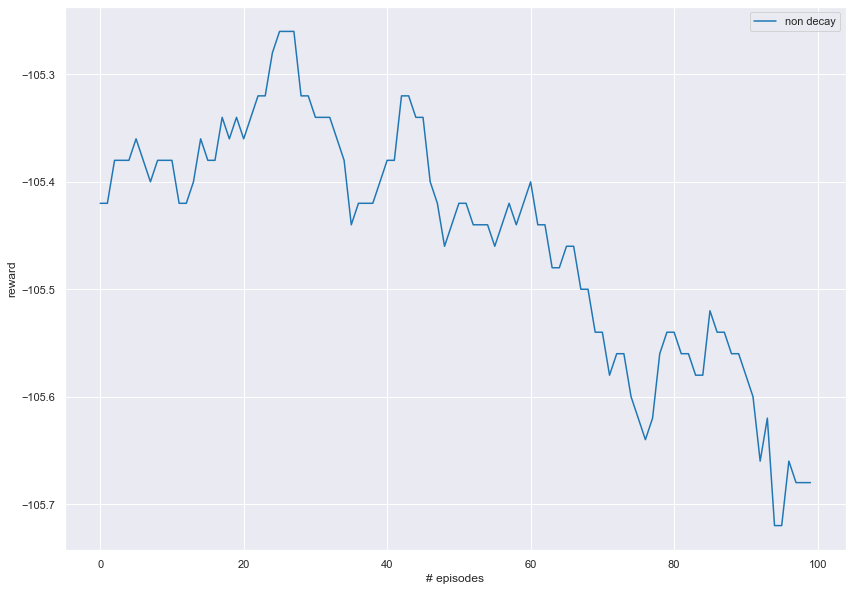

In [352]:
 rewards = OnPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      linear_decay=True,
                      alpha=0.5,
                      gamma=0.9,
                      steps=STEPS,
                      verbose=False,
                    )
    
mean_rewards = [sum(rewards[i: i + 50]) / 50 for i in range(STEPS // 50)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[0], label="non decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

### Experiment with different variations

In [351]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

Training: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 287.91it/s]


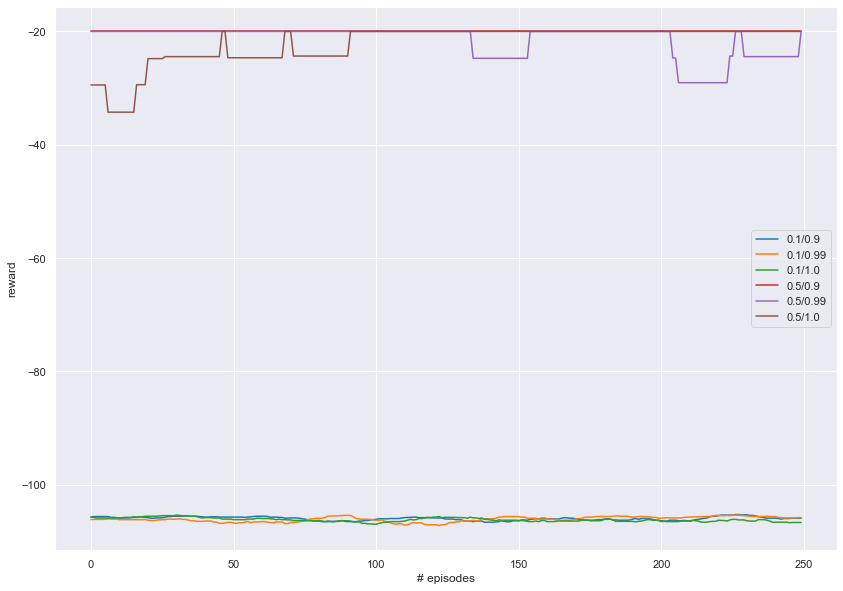

In [355]:
color_idx = 0
for alpha in ALPHA:
    for gamma in GAMMA:
        rewards = OffPolicy(
                              env=env, 
                              eps=EPS,
                              expo_decay=False,
                              linear_decay=False,
                              alpha=alpha,
                              gamma=gamma,
                              steps=STEPS,
                              verbose=False,
                            )

        mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
        x_points = np.array([i for i in range(len(mean_rewards))])
        y_points = mean_rewards
        plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="{}/{}".format(alpha, gamma))
        plt.set(xlabel="# episodes", ylabel="reward")
        plt.legend()
        
        color_idx += 1

Training: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 280.27it/s]


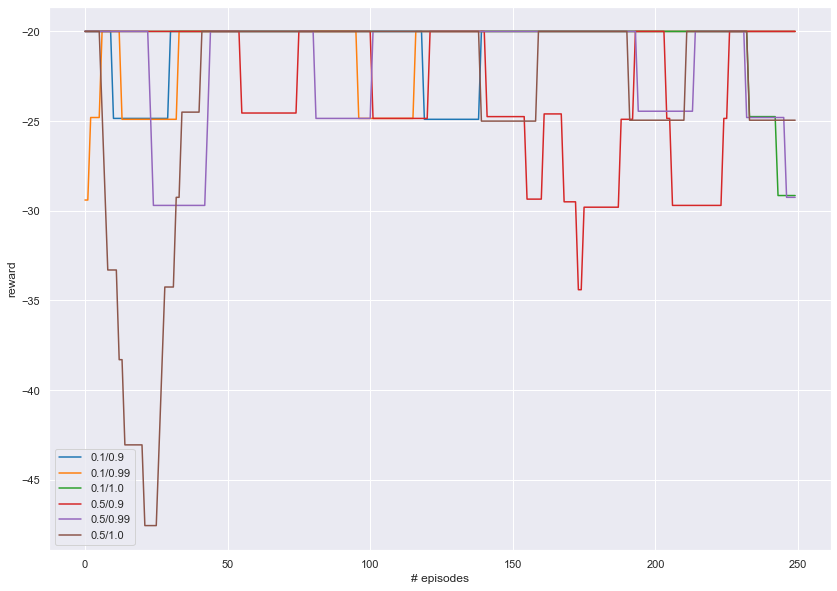

In [356]:
color_idx = 0
for alpha in ALPHA:
    for gamma in GAMMA:
        rewards = OffPolicy(
                              env=env, 
                              eps=EPS,
                              expo_decay=True,
                              linear_decay=False,
                              alpha=alpha,
                              gamma=gamma,
                              steps=STEPS,
                              verbose=False,
                            )

        mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
        x_points = np.array([i for i in range(len(mean_rewards))])
        y_points = mean_rewards
        plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="{}/{}".format(alpha, gamma))
        plt.set(xlabel="# episodes", ylabel="reward")
        plt.legend()
        
        color_idx += 1

Training: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 336.71it/s]


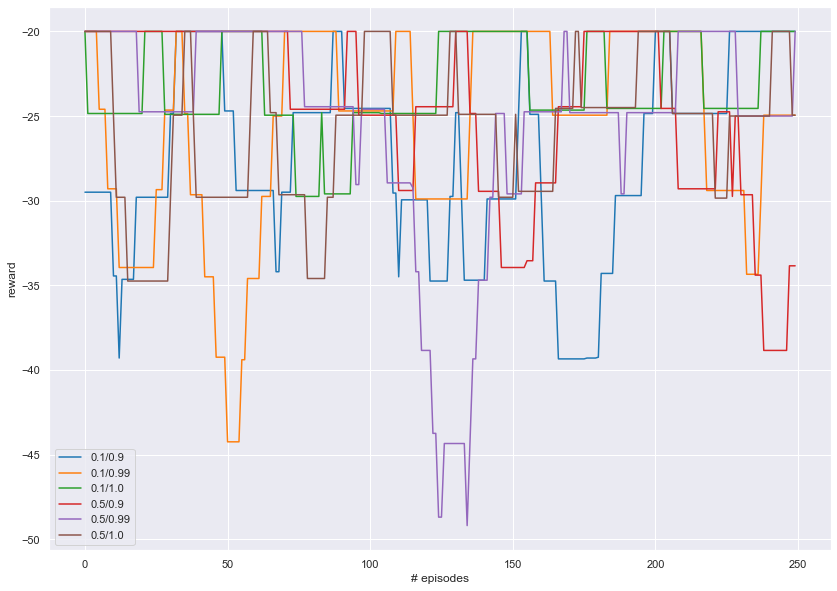

In [360]:
color_idx = 0
for alpha in ALPHA:
    for gamma in GAMMA:
        rewards = OffPolicy(
                              env=env, 
                              eps=EPS,
                              expo_decay=False,
                              linear_decay=True,
                              alpha=alpha,
                              gamma=gamma,
                              steps=STEPS,
                              verbose=False,
                            )

        mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
        x_points = np.array([i for i in range(len(mean_rewards))])
        y_points = mean_rewards
        plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="{}/{}".format(alpha, gamma))
        plt.set(xlabel="# episodes", ylabel="reward")
        plt.legend()
        
        color_idx += 1

Training: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 277.90it/s]


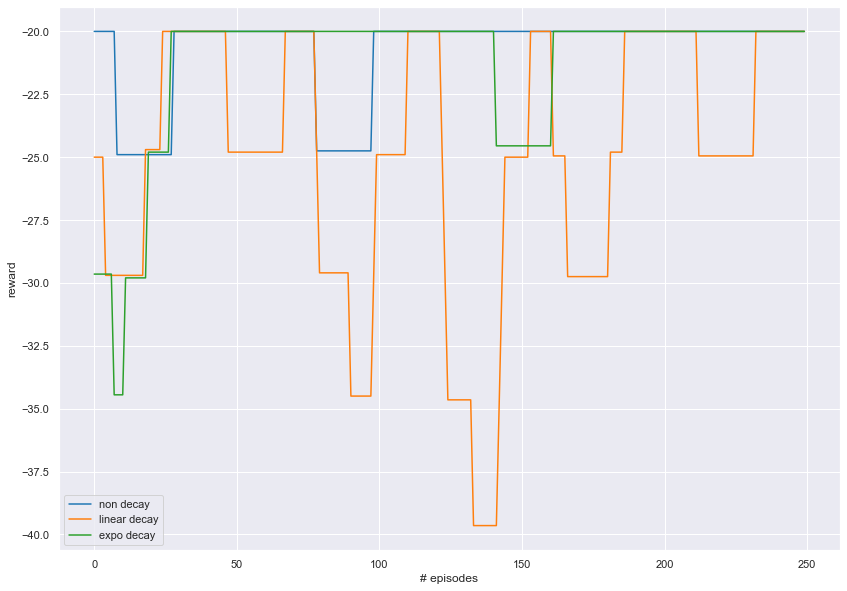

In [361]:
ALPHA = 0.75
GAMMA = 0.95

color_idx = 0
rewards = OffPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      linear_decay=False,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="non decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

rewards = OffPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      linear_decay=True,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="linear decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

rewards = OffPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=True,
                      decay_rate=0.9,
                      linear_decay=False,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="expo decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

Training: 100%|███████████████████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 544.86it/s]


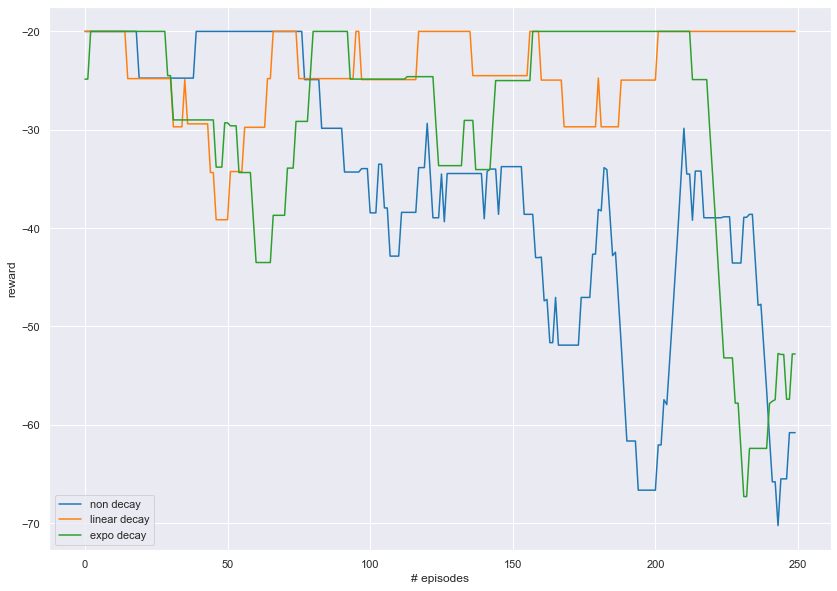

In [362]:
ALPHA = 0.75
GAMMA = 0.95

color_idx = 0
rewards = OnPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      linear_decay=False,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="non decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

rewards = OnPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=False,
                      linear_decay=True,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="linear decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

rewards = OnPolicy(
                      env=env, 
                      eps=EPS,
                      expo_decay=True,
                      decay_rate=0.9,
                      linear_decay=False,
                      alpha=ALPHA,
                      gamma=GAMMA,
                      steps=STEPS,
                      verbose=False,
                    )

mean_rewards = [sum(rewards[i: i + 20]) / 20 for i in range(STEPS // 20)]
x_points = np.array([i for i in range(len(mean_rewards))])
y_points = mean_rewards
plt = sns.lineplot(x=x_points, y=y_points, color=sns.color_palette("tab10")[color_idx], label="expo decay")
plt.set(xlabel="# episodes", ylabel="reward")
plt.legend()

color_idx += 1

In [ ]:
#